In [1328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup
from collections import defaultdict
import time
import yfinance as yf

import statsmodels.api as sm
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')

### Scrape fundamentals table and peer tickers from Finviz

In [1333]:
def get_finviz_data_and_peers(ticker):
    url = f"https://finviz.com/quote.ashx?t={ticker}&p=d"
    headers = {"User-Agent": "Mozilla/5.0"}
    res = requests.get(url, headers=headers)
    soup = BeautifulSoup(res.text, 'html.parser')

    # Extract fundamentals
    data = defaultdict(list)  # allow multiple values per key
    try:
        table = soup.find("table", class_="snapshot-table2")
        rows = table.find_all("tr")
        for row in rows:
            cells = row.find_all("td")
            for i in range(0, len(cells), 2):
                key = cells[i].text.strip()
                val = cells[i + 1].text.strip()
                data[key].append(val)
    except Exception as e:
        print(f"[{ticker}] Error parsing fundamentals: {e}")

    # Convert to dict with numbered keys if duplicates exist
    deduped_data = {}
    for key, values in data.items():
        if len(values) == 1:
            deduped_data[key] = values[0]
        else:
            for i, val in enumerate(values):
                deduped_data[f"{key}_{i+1}"] = val

    # Extract peers from tab-link
    peers = []
    try:
        tab_links = soup.find_all("a", class_="tab-link")
        for link in tab_links:
            if "Peers" in link.text and "screener.ashx?t=" in link["href"]:
                peer_str = link["href"].split("t=")[1]
                peers = peer_str.split(",")
                peers = [p for p in peers if p != ticker]  # exclude self
                break
    except Exception as e:
        print(f"[{ticker}] Error extracting peers: {e}")

    return deduped_data, peers


def get_peer_group_data(main_ticker):
    # Get data
    main_data, peers = get_finviz_data_and_peers(main_ticker)
    print(f'Peer group: {peers}')
    
    # Combine tickers: main + peers
    tickers = [main_ticker] + peers
    all_data = []
    
    # Scrape each ticker's fundamentals
    for ticker in tickers:
        print(f"Scraping {ticker}...")
        data, _ = get_finviz_data_and_peers(ticker)
        data["Ticker"] = ticker
        all_data.append(data)
        time.sleep(1.5)
    
    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    df.set_index("Ticker", inplace=True)

    return df


df = get_peer_group_data(main_ticker="GOOGL")

Peer group: ['META', 'MSFT', 'AMZN', 'AAPL', 'SPOT', 'NFLX', 'PINS', 'SNAP', 'ROKU', 'TTD']
Scraping GOOGL...
Scraping META...
Scraping MSFT...
Scraping AMZN...
Scraping AAPL...
Scraping SPOT...
Scraping NFLX...
Scraping PINS...
Scraping SNAP...
Scraping ROKU...
Scraping TTD...


### Clean peer group data

In [1336]:
def clean_value(val):
    if isinstance(val, (float, int)):
        return val
    if isinstance(val, str):
        val = val.strip().replace(",", "").replace("(", "").replace(")", "")
        if val.endswith("B"):
            return float(val[:-1]) * 1e9
        elif val.endswith("M"):
            return float(val[:-1]) * 1e6
        elif val.endswith("%"):
            try:
                return float(val[:-1]) / 100
            except:
                return None
        elif val == "-":
            return None
        try:
            return float(val)
        except:
            return val  # e.g., "Yes", "N/A"
    return val


def split_and_clean(cell):
    parts = str(cell).split()
    if len(parts) == 2:
        return [clean_value(parts[0]), clean_value(parts[1])]
    return [clean_value(cell), None]


# Columns that contain dual values in a single string cell
dual_value_cols = {
    '52W High': ('52W_high_price', '52W_high_distance'),
    'EPS past 3/5Y': ('EPS_growth_3Y', 'EPS_growth_5Y'),
    '52W Low': ('52W_low_price', '52W_low_distance'),
    'Dividend Est.': ('dividend_est', 'dividend_yield_est'),
    'Sales past 3/5Y': ('Sales_growth_3Y', 'Sales_growth_5Y'),
    'Volatility': ('volatility_week', 'volatility_month'),
    'Dividend TTM': ('dividend_ttm', 'dividend_yield_ttm'),
    'Dividend Gr. 3/5Y': ('dividend_growth_3Y', 'dividend_growth_5Y'),
    #'Option/Short': ('Option_available', 'Short_available'),
    'EPS/Sales Surpr.': ('EPS_surprise', 'Sales_surprise'),
}

peers_df = df.copy().drop(columns=['Option/Short','Index'])

# Process dual-value columns
for orig_col, (col1, col2) in dual_value_cols.items():
    val_pairs = df[orig_col].apply(split_and_clean).tolist()
    peers_df[[col1, col2]] = pd.DataFrame(val_pairs, index=peers_df.index)
    peers_df.drop(columns=orig_col, inplace=True)

# Clean all remaining object columns
peers_df = peers_df.applymap(clean_value)
peers_df

,P/E,EPS (ttm),Insider Own,Shs Outstand,Perf Week,Market Cap,Forward P/E,EPS next Y_1,EPS next Y_2,Insider Trans,...,Sales_growth_3Y,Sales_growth_5Y,volatility_week,volatility_month,dividend_ttm,dividend_yield_ttm,dividend_growth_3Y,dividend_growth_5Y,EPS_surprise,Sales_surprise
Ticker,,,,,,,,,,,,,,,,,,,,,
GOOGL,19.91,8.97,0.5217,5.830000e+09,0.0714,2.165040e+12,17.56,10.16,0.0602,-0.0001,...,0.1075,0.1673,0.0274,0.0230,0.81,0.0045,NaN,NaN,0.3881,0.0115
META,28.62,25.64,0.1378,2.180000e+09,0.0752,1.844450e+12,25.91,28.31,0.1056,-0.0040,...,0.1173,0.1840,0.0198,0.0209,2.05,0.0028,NaN,NaN,0.2283,0.0236
MSFT,38.32,12.94,0.0148,7.430000e+09,0.0388,3.686100e+12,32.72,15.16,0.1316,-0.0012,...,0.1340,0.1433,0.0153,0.0125,2.41,0.0049,0.1023,0.1027,0.0738,0.0238
AMZN,36.42,6.13,0.1058,1.061000e+10,0.0649,2.370630e+12,30.67,7.28,0.1736,-0.0002,...,0.1074,0.1786,0.0225,0.0213,NaN,NaN,NaN,NaN,0.1638,0.0033
AAPL,31.38,6.41,0.0010,1.494000e+10,0.0004,3.003300e+12,25.88,7.77,0.0839,-0.0128,...,0.0225,0.0851,0.0160,0.0190,1.01,0.0050,0.0486,0.0550,0.0139,0.0086
SPOT,127.35,6.07,0.2518,2.050600e+08,0.0921,1.551300e+11,54.00,14.31,0.4604,0.0000,...,0.1405,0.1750,0.0359,0.0320,NaN,NaN,NaN,NaN,-0.5103,0.0007
NFLX,62.52,21.16,0.0066,4.256800e+08,0.0745,5.630800e+11,42.67,31.01,0.2149,-0.2262,...,0.0939,0.1404,0.0237,0.0209,NaN,NaN,NaN,NaN,0.1654,0.0034
PINS,13.05,2.75,0.1354,5.936900e+08,0.0506,2.432000e+10,17.05,2.11,0.1742,-0.0164,...,0.1225,0.2612,0.0346,0.0280,NaN,NaN,NaN,NaN,-0.0987,0.0101
SNAP,NaN,-0.32,0.3580,1.430000e+09,0.0886,1.457000e+10,NaN,-0.32,0.2172,-0.0053,...,0.0920,0.2560,0.0485,0.0418,NaN,NaN,NaN,NaN,0.3994,0.0133


### Specify directional impact of metric on ranking score calculation (higher score the better)

In [1339]:
decrease_score_list = [
    # other inputs
    'SMA20',
    'SMA50',
    'SMA200',
    'RSI (14)',
    '52W_high_distance',
    
    # low valuation multiples
    'PEG',
    'P/E',
    'Forward P/E',
    'P/S',
    'P/B',
    'P/C',
    'P/FCF',
    'EV/Sales',
    'EV/EBITDA',

    # low leverage
    'LT Debt/Eq',
    'Debt/Eq',

    # less volatile
    'Beta',
    'ATR (14)',
    'volatility_week',
    'volatility_month',

    # less shorted
    'Short Interest',
    'Short Float',
    'Short Ratio',
]

increase_score_list = [
    # other inputs
    'Recom',
    '52W_low_distance',
    'Insider Trans',
    'Inst Trans',
    
    # EPS performance
    'EPS (ttm)',
    'EPS next Y_1',
    'EPS next Y_2',
    'EPS next Q',
    'EPS this Y',
    'EPS next 5Y',
    'EPS Y/Y TTM',
    'EPS Q/Q',
    'EPS_growth_3Y',
    'EPS_growth_5Y',
    'EPS_surprise',
    
    # Sales performance
    'Sales',
    'Sales Y/Y TTM',
    'Sales Q/Q',
    'Sales_growth_3Y',
    'Sales_growth_5Y',
    'Sales_surprise',
    
    # price performance
    'Change',
    'Perf Week',
    'Perf Month',
    'Perf Quarter',
    'Perf Half Y',
    'Perf YTD',
    'Perf Year',
    'Perf 3Y',
    'Perf 5Y',
    'Perf 10Y',
    
    # profitability
    'Gross Margin',
    'Oper. Margin',
    'Profit Margin',
    'ROA',
    'ROE',
    'ROIC',
    
    # dividends
    'dividend_est',
    'dividend_yield_est',
    'dividend_ttm',
    'dividend_yield_ttm',
    'dividend_growth_3Y',
    'dividend_growth_5Y',
    
    # other fundamentals
    'Market Cap',
    'Enterprise Value',
    'Income',
    'Book/sh',
    'Cash/sh',
    'Quick Ratio',
    'Current Ratio',
    
    # volume
    'Rel Volume',
    'Avg Volume',
    'Volume',
]

unused = [
    'Insider Own',
    'Shs Outstand',
    'Inst Own',
    'Shs Float',
    'Target Price',
    'Payout',
    'Employees',
    '52W_high_price',
    '52W_low_price',
    'Price',
    'Prev Close',

    # non-numeric cols
    # 'Trades',
    # 'Dividend Ex-Date',
    # 'IPO',
    # 'Earnings',
]

### Group metrics to compute metric-neutral ranking scores

In [1342]:
metric_groups = {
    'multiples': [
        'PEG',
        'P/E',
        'Forward P/E',
        'P/S',
        'P/B',
        'P/C',
        'P/FCF',
        'EV/Sales',
        'EV/EBITDA'
    ],
    
    'growth': [
        # EPS growth
        'EPS next Y_2',
        'EPS this Y',
        'EPS next 5Y',
        'EPS Y/Y TTM',
        'EPS Q/Q',
        'EPS_growth_3Y',
        'EPS_growth_5Y',
        'EPS_surprise',
        # Sales growth
        'Sales Y/Y TTM',
        'Sales Q/Q',
        'Sales_growth_3Y',
        'Sales_growth_5Y',
        'Sales_surprise',
        # dividend growth
        # 'dividend_growth_3Y',
        # 'dividend_growth_5Y'
    ],
    
    'profitability':[
        # profitability
        'Gross Margin',
        'Oper. Margin',
        'Profit Margin',
        'ROA',
        'ROE',
        'ROIC'
    ],
    
    'financial_health': [
    # Liquidity ratios
    'Quick Ratio',
    'Current Ratio',
    # low leverage
    'LT Debt/Eq',
    'Debt/Eq'
    ],

    # 'volatility': [
    #     'Beta',
    #     'ATR (14)',
    #     'volatility_week',
    #     'volatility_month',
    # ],

    'fundamentals_per_share': [
        'EPS (ttm)',
        'EPS next Y_1',
        'EPS next Q',
        'Book/sh',
        'Cash/sh',
    ],

    'fundamentals_absolute': [
        'Market Cap',
        'Enterprise Value',
        'Income',
        'Sales',
    ],

    # 'other_signals': [
    #     'Recom',
    #     'Insider Trans',
    #     'Inst Trans',
    # ],
    
    # 'momentum': [
    #     'Change',
    #     'Perf Week',
    #     'Perf Month',
    #     'Perf Quarter',
    #     'Perf Half Y',
    #     'Perf YTD',
    #     'Perf Year',
    #     'Perf 3Y',
    #     'Perf 5Y',
    #     'Perf 10Y',
    # ],
}

### Mapping metric directional adjustments and groupping to peer group metric values data

In [1345]:
# restructure data to melted format
peers_df_melted = peers_df.reset_index().melt(id_vars='Ticker', var_name='metrics')

# adjust for directional metric values adjustment
condlist = [
    peers_df_melted['metrics'].isin(increase_score_list), 
    peers_df_melted['metrics'].isin(decrease_score_list)
]
choicelist = [1, -1]
peers_df_melted['score_direction_adj'] = np.select(condlist, choicelist, 0)
peers_df_melted['value_direction_adj'] = peers_df_melted['value'] * peers_df_melted['score_direction_adj']

# filter data for only metrics used
val_list = [metric for group in metric_groups.values() for metric in group]
peers_df_melted = peers_df_melted[peers_df_melted.metrics.isin(val_list)]

# map metric groups
metric_to_group = {metric: group for group, metrics in metric_groups.items() for metric in metrics}
peers_df_melted['metric_groups'] = peers_df_melted['metrics'].map(metric_to_group)
peers_df_melted

,Ticker,metrics,value,score_direction_adj,value_direction_adj,metric_groups
0,GOOGL,P/E,19.91,-1,-19.91,multiples
1,META,P/E,28.62,-1,-28.62,multiples
2,MSFT,P/E,38.32,-1,-38.32,multiples
3,AMZN,P/E,36.42,-1,-36.42,multiples
4,AAPL,P/E,31.38,-1,-31.38,multiples
...,...,...,...,...,...,...
996,NFLX,Sales_surprise,0.0034,1,0.0034,growth
997,PINS,Sales_surprise,0.0101,1,0.0101,growth
998,SNAP,Sales_surprise,0.0133,1,0.0133,growth
999,ROKU,Sales_surprise,0.013,1,0.013,growth


### Rank by metric values
How to combine factor scores:
https://github.com/hyunyulhenry/quant_py/blob/main/factor.ipynb

,P/E,EPS (ttm),Insider Own,Shs Outstand,Perf Week,Market Cap,Forward P/E,EPS next Y_1,EPS next Y_2,Insider Trans,...,volatility_week,volatility_month,dividend_ttm,dividend_yield_ttm,dividend_growth_3Y,dividend_growth_5Y,EPS_surprise,Sales_surprise,agg_composite_score,agg_final_rank
Ticker,,,,,,,,,,,,,,,,,,,,,
PINS,13.05,2.75,0.1354,5.936900e+08,0.0506,2.432000e+10,17.05,2.11,0.1742,-0.0164,...,0.0346,0.0280,NaN,NaN,NaN,NaN,-0.0987,0.0101,21.094461,1.0
META,28.62,25.64,0.1378,2.180000e+09,0.0752,1.844450e+12,25.91,28.31,0.1056,-0.0040,...,0.0198,0.0209,2.05,0.0028,NaN,NaN,0.2283,0.0236,18.773509,2.0
GOOGL,19.91,8.97,0.5217,5.830000e+09,0.0714,2.165040e+12,17.56,10.16,0.0602,-0.0001,...,0.0274,0.0230,0.81,0.0045,NaN,NaN,0.3881,0.0115,14.389499,3.0
MSFT,38.32,12.94,0.0148,7.430000e+09,0.0388,3.686100e+12,32.72,15.16,0.1316,-0.0012,...,0.0153,0.0125,2.41,0.0049,0.1023,0.1027,0.0738,0.0238,2.274309,4.0
AMZN,36.42,6.13,0.1058,1.061000e+10,0.0649,2.370630e+12,30.67,7.28,0.1736,-0.0002,...,0.0225,0.0213,NaN,NaN,NaN,NaN,0.1638,0.0033,-3.060186,5.0
ROKU,NaN,-0.73,0.1236,1.295300e+08,0.0735,1.275000e+10,136.24,0.64,4.1100,-0.0102,...,0.0377,0.0367,NaN,NaN,NaN,NaN,0.2709,0.0130,-3.119534,6.0
TTD,84.79,0.82,0.0933,4.480200e+08,0.0161,3.407000e+10,61.84,1.12,0.3219,-0.0333,...,0.0385,0.0374,NaN,NaN,NaN,NaN,-0.2743,0.0708,-4.811054,7.0
NFLX,62.52,21.16,0.0066,4.256800e+08,0.0745,5.630800e+11,42.67,31.01,0.2149,-0.2262,...,0.0237,0.0209,NaN,NaN,NaN,NaN,0.1654,0.0034,-7.635601,8.0
SPOT,127.35,6.07,0.2518,2.050600e+08,0.0921,1.551300e+11,54.00,14.31,0.4604,0.0000,...,0.0359,0.0320,NaN,NaN,NaN,NaN,-0.5103,0.0007,-7.715552,9.0


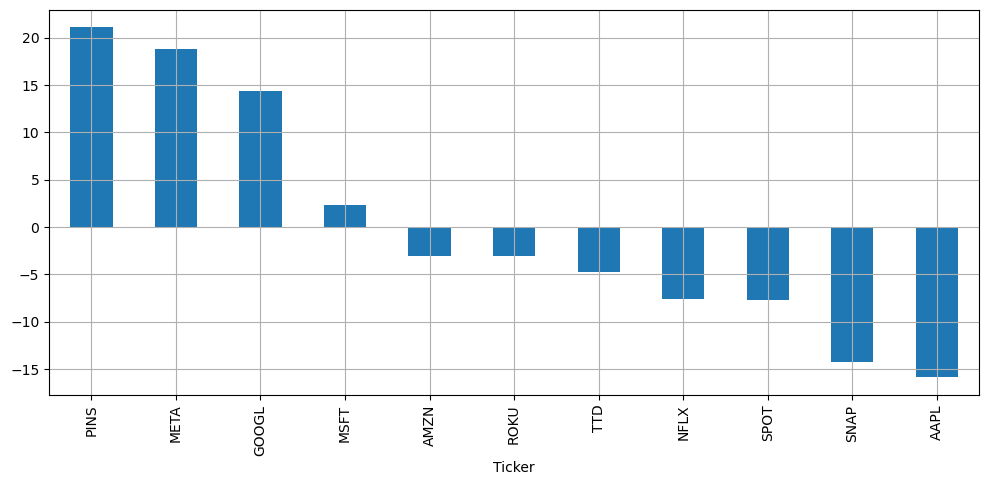

In [1348]:
# higher the better value_direction_adj -> higher the larger rank number (highest = last) -> higher zscore conversion
peers_df_melted['metric_rank'] = peers_df_melted.groupby(['metrics']).value_direction_adj.rank(axis=0)
#peers_df_melted['metric_rank_z'] = peers_df_melted.groupby(['metrics'])['metric_rank'].transform(lambda x: zscore(x, nan_policy='omit'))
peers_df_melted['metric_rank_z'] = peers_df_melted.groupby(['metric_groups'])['metric_rank'].transform(lambda x: zscore(x, nan_policy='omit'))
peers_df_melted['agg_composite_score'] = peers_df_melted.groupby(['Ticker']).metric_rank_z.transform(sum)

# higher agg_composite_score the smaller rank number (highest = 1st)
agg_composite_score = peers_df_melted.groupby(['Ticker'])['agg_composite_score'].first().sort_values(ascending=False).to_frame()
agg_composite_score['agg_final_rank'] = agg_composite_score.agg_composite_score.rank(ascending=False)

peers_ranked_df = peers_df.merge(agg_composite_score, how='left', on='Ticker').sort_values(by='agg_composite_score', ascending=False)
display(peers_ranked_df)

fig,ax = plt.subplots(figsize=(12, 5))
peers_ranked_df.agg_composite_score.plot(kind='bar', ax=ax)
ax.grid();

Intercept: 0.11033636363636362
Slope: 0.00450143918451529
R-squared: 0.03117317129665531


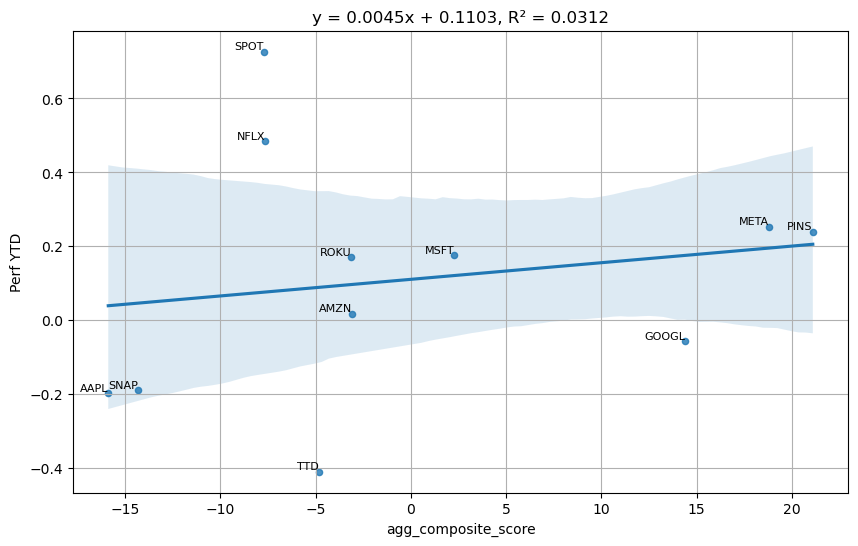

In [1354]:
fig,ax = plt.subplots(figsize=(10, 6))
x_var = "agg_composite_score" # agg_final_rank agg_composite_score
y_var = "Perf YTD" 

plot_df = peers_ranked_df
sns.regplot(plot_df, x=x_var, y=y_var, 
            order=1, scatter_kws={"s": 20}, ax=ax)

# Add labels (index = ticker)
for i in plot_df.index:
    x = plot_df.loc[i, x_var]
    y = plot_df.loc[i, y_var]
    if pd.notnull(x) and pd.notnull(y):
        ax.text(x, y, i, fontsize=8, ha='right', va='bottom')

ax.set(xscale="linear", yscale="linear")
#ax.legend()
ax.grid();

x = plot_df[x_var]
y = plot_df[y_var]
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

slope = model.params['agg_composite_score']
intercept = model.params['const']
r2_value = model.rsquared

print("Intercept:", intercept)
print("Slope:", slope)
print("R-squared:", r2_value)
ax.set_title(f"y = {slope:.4f}x + {intercept:.4f}, R² = {r2_value:.4f}");

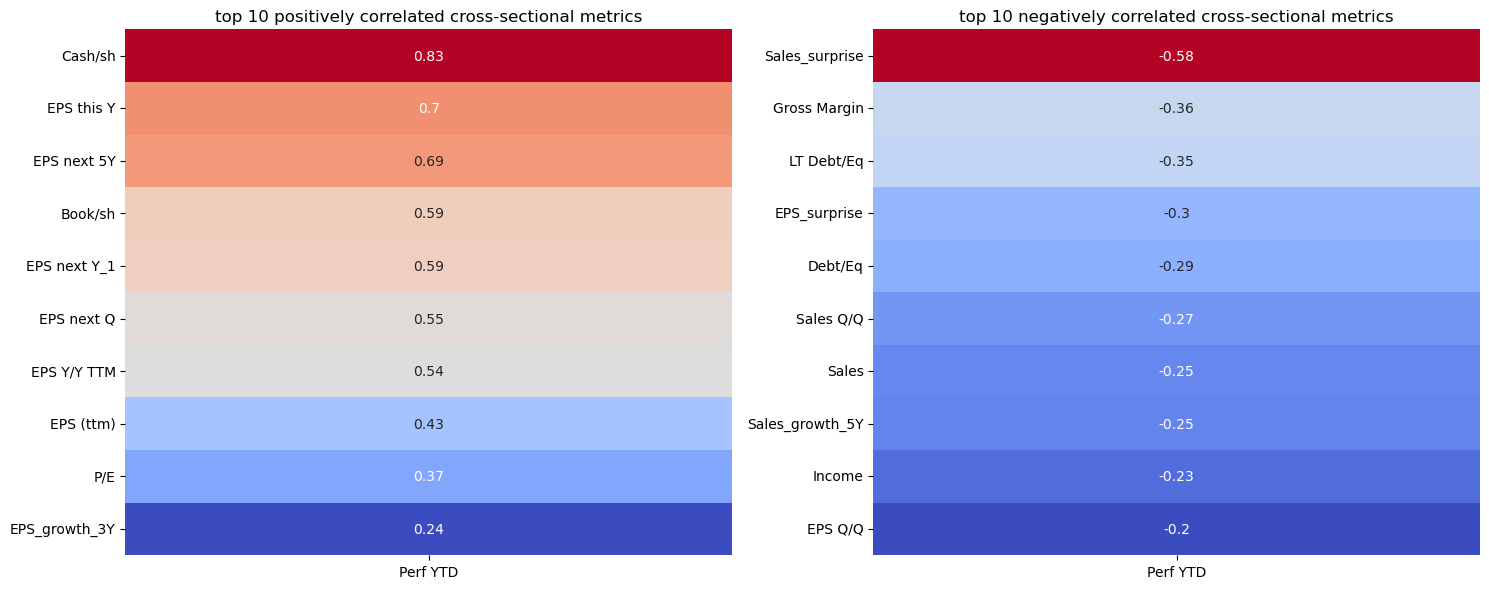

In [1356]:
fig,ax = plt.subplots(1, 2, figsize=(15,6), sharex=True)

# Perf YTD Perf Quarter Perf Year
subset_df = peers_ranked_df.select_dtypes(exclude='object').corr()['Perf YTD']
subset_df = subset_df[val_list].sort_values().to_frame()
#.drop(columns=unused).drop(columns=subset_df.filter(regex='Perf.*', axis=1).columns)[val_list]

n_metrics = 10
ax[0].set_title(f'top {n_metrics} positively correlated cross-sectional metrics')
sns.heatmap(subset_df.tail(n_metrics).iloc[::-1], annot=True, cmap='coolwarm', cbar=False, ax=ax[0]);
ax[1].set_title(f'top {n_metrics} negatively correlated cross-sectional metrics')
sns.heatmap(subset_df.head(n_metrics), annot=True, cmap='coolwarm_r', cbar=False, ax=ax[1]);

plt.tight_layout();